# Liquidation Analysis

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import graphistry
import matplotlib.pyplot as plt
from web3 import Web3

## Loading Data

In [2]:
transactions = pd.read_csv('transactions.csv')
transactions.info()

/usr/local/etc/anaconda3/envs/blockchain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,13,14,16,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541596 entries, 0 to 541595
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   amount                     532010 non-null  float64
 1   borrowRate                 107289 non-null  float64
 2   borrowRateMode             107289 non-null  object 
 3   onBehalfOf                 532010 non-null  object 
 4   pool                       541596 non-null  object 
 5   reserve                    534881 non-null  object 
 6   timestamp                  541596 non-null  int64  
 7   user                       541596 non-null  object 
 8   type                       541596 non-null  object 
 9   reservePriceETH            532010 non-null  float64
 10  reservePriceUSD            532010 non-null  float64
 11  amountUSD                  532010 non-null  float64
 12  collateralAmount           6715 non-null    float64
 13  collateralReserve          67

In [3]:
def removeSmarts(df):
    smarts=['0xB53C1a33016B2DC2fF3653530bfF1848a515c8c5',
              '0x52D306e36E3B6B02c153d0266ff0f85d18BCD413',
              '0x7d2768dE32b0b80b7a3454c06BdAc94A69DDc7A9',
              '0xbd4765210d4167CE2A5b87280D9E8Ee316D5EC7C',
              '0x311Bb771e4F8952E6Da169b425E7e92d6Ac45756',
              '0x8A32f49FFbA88aba6EFF96F45D8BD1D4b3f35c7D',
              '0xA50ba011c48153De246E5192C8f9258A2ba79Ca9',
              '0xB9062896ec3A615a4e4444DF183F0531a77218AE',
              '0xB9062896ec3A615a4e4444DF183F0531a77218AE',
              '0x057835Ad21a177dbdd3090bB1CAE03EaCF78Fc6d',
              '0xcc9a0B7c43DC2a5F023Bb9b738E45B0Ef6B06E04',
              '0x464C71f6c2F760DdA6093dCB91C24c39e5d6e18c',
              '0xd784927Ff2f95ba542BfC824c8a8a98F3495f6b5',
               '0xAcc030EF66f9dFEAE9CbB0cd1B25654b82cFA8d5',
               '0x7937d4799803fbbe595ed57278bc4ca21f3bffcb',
               '0xbd4765210d4167ce2a5b87280d9e8ee316d5ec7c',
               '0x23a875ede3f1030138701683e42e9b16a7f87768',
               '0x8a32f49ffba88aba6eff96f45d8bd1d4b3f35c7d',
               '0xa50ba011c48153de246e5192c8f9258a2ba79ca9',
               '0xc443AD9DDE3cecfB9dfC5736578f447aFE3590ba',
               '0xcc9a0B7c43DC2a5F023Bb9b738E45B0Ef6B06E04',
               '0x464C71f6c2F760DdA6093dCB91C24c39e5d6e18c']

    for i in range(len(smarts)):
        smarts[i]=smarts[i].lower()

    df =df[~df['user'].isin(smarts)]
    return df

transactions = removeSmarts(transactions)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485341 entries, 1 to 541595
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   amount                     475755 non-null  float64
 1   borrowRate                 101977 non-null  float64
 2   borrowRateMode             101977 non-null  object 
 3   onBehalfOf                 475755 non-null  object 
 4   pool                       485341 non-null  object 
 5   reserve                    478626 non-null  object 
 6   timestamp                  485341 non-null  int64  
 7   user                       485341 non-null  object 
 8   type                       485341 non-null  object 
 9   reservePriceETH            475755 non-null  float64
 10  reservePriceUSD            475755 non-null  float64
 11  amountUSD                  475755 non-null  float64
 12  collateralAmount           6715 non-null    float64
 13  collateralReserve          67

In [4]:
#load in data
liquidations = pd.read_csv('liquidations.csv')
liquidations = removeSmarts(liquidations)
liquidations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6725 entries, 0 to 6724
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   collateralAmount           6725 non-null   float64
 1   collateralReserve          6725 non-null   object 
 2   liquidator                 6725 non-null   object 
 3   pool                       6725 non-null   object 
 4   principalAmount            6725 non-null   float64
 5   principalReserve           6725 non-null   object 
 6   timestamp                  6725 non-null   int64  
 7   user                       6725 non-null   object 
 8   type                       6725 non-null   object 
 9   reservePriceETHPrincipal   6547 non-null   float64
 10  reservePriceUSDPrincipal   6547 non-null   float64
 11  reservePriceETHCollateral  3788 non-null   float64
 12  reservePriceUSDCollateral  3788 non-null   float64
 13  amountUSDPincipal          6547 non-null   float

In [5]:
#create user dictionary to keep track of which users have liquidations
users=dict()
liquidators=[]
nonliquidators=[]

#group transactions by user
groups = transactions.groupby('user')

#go through each users' transactions
for ID, group in groups:
    #check for liquidation
    if 'liquidation' in group['type'].values:
        users[ID]='Liquidator'
        liquidators.append(ID)
    else:
        users[ID]='Non-Liquidator'
        nonliquidators.append(ID)
        
print(len(users))

43940


In [6]:
def isLiquidators(row):
    if row['user'] in liquidators:
        return True
    else:
        return False
        
transactions['isLiquidator']= transactions.apply(lambda x: isLiquidators(x),axis=1)
transactions['isLiquidator'].describe()

count     485341
unique         2
top        False
freq      407254
Name: isLiquidator, dtype: object

## Analysis

In [7]:
#set plot theme
sns.set_theme(style="darkgrid")

### How Many Liquidations Have Taken Place?

In [8]:
len(liquidations)

6725

### How Many Users Have Liquidated?

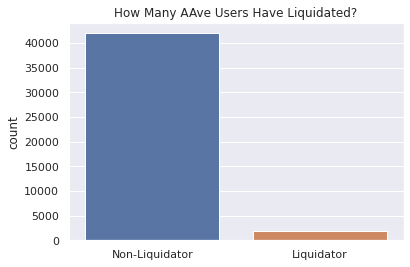

In [9]:
#create countplot
sns.countplot(x=list(users.values()))
plt.title('How Many AAve Users Have Liquidated?')
plt.show()

### How Many Liquidators are There?

In [10]:
len(liquidations['liquidator'].unique())

133

### How Many Actions Do Liquidators Take?

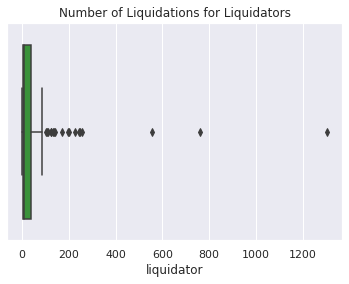

In [11]:
#create boxplot
sns.boxplot(x=liquidations['liquidator'].value_counts(),color=sns.color_palette("tab10")[2])
plt.title('Number of Liquidations for Liquidators')
plt.show()

### How Many Liquidations do Liquidatees' Recieve?

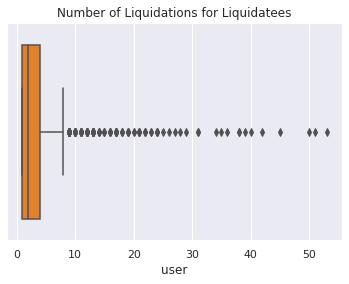

In [12]:
#create boxplot
sns.boxplot(x=liquidations['user'].value_counts(),color=sns.color_palette("tab10")[1])
plt.title('Number of Liquidations for Liquidatees')
plt.show()

### What do the Connections Between Liquidators and Liquidatees Look Like?

In [13]:
graphistry.register(api=3,username='Chris95cam',password='x@9DePmTfLPi@2a')
g = graphistry.edges(liquidations,'liquidator','user')
g.plot()

### What are Unique Characteristics of Liquidators vs Non Liquidators?

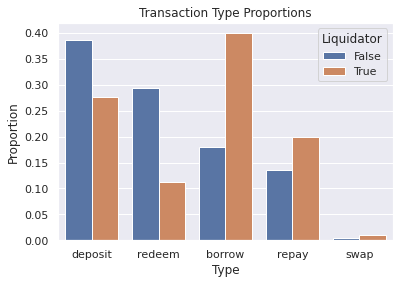

In [14]:
#get dataframes of transactions for liquidators and nonliquidators
transactions_liquidators = transactions[transactions['isLiquidator']]
transactions_nonliquidators = transactions[~transactions['isLiquidator']]

#get proportions of transaction types for each type of user
prop_nonliquidators = transactions_nonliquidators['type'].value_counts()/len(transactions_nonliquidators)
prop_liquidators = transactions_liquidators['type'].value_counts()[['deposit','borrow','repay','redeem','swap']]/len(transactions_liquidators[~(transactions_liquidators['type']=='liquidation')])

#create dataframe that will be used to plot data
df_props_nonliquid = pd.DataFrame(prop_nonliquidators)
df_props_nonliquid['Liquidator']=False
df_props_liquid = pd.DataFrame(prop_liquidators)
df_props_liquid['Liquidator']=True
df_props = df_props_nonliquid.append(df_props_liquid)
df_props.reset_index(inplace=True)

#create plot
sns.barplot(data=df_props,x='index',y='type',hue='Liquidator')
plt.title('Transaction Type Proportions')
plt.xlabel('Type')
plt.ylabel('Proportion')
plt.show()

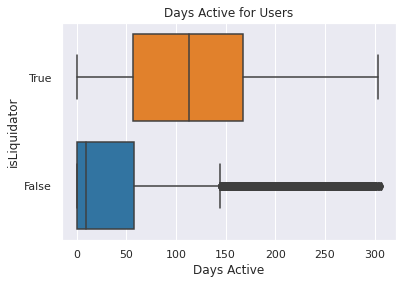

In [15]:
#get days active for both type of users
days_active_liquidators = (transactions_liquidators.groupby('user')['timestamp'].max()-transactions_liquidators.groupby('user')['timestamp'].min())/(3600*24)
days_active_nonliquidators = (transactions_nonliquidators.groupby('user')['timestamp'].max()-transactions_nonliquidators.groupby('user')['timestamp'].min())/(3600*24)

#create dataframe to be plotted
active_liquidators = pd.DataFrame(days_active_liquidators)
active_liquidators['isLiquidator']='True'
active_nonliquidators = pd.DataFrame(days_active_nonliquidators)
active_nonliquidators['isLiquidator']='False'
active = active_liquidators.append(active_nonliquidators)

#create boxplot
sns.boxplot(data=active,x='timestamp',y='isLiquidator',palette=[sns.color_palette("tab10")[1],sns.color_palette("tab10")[0]])
plt.title('Days Active for Users')
plt.xlabel('Days Active')
plt.show()

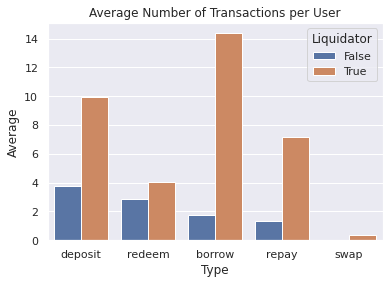

In [16]:
#get dataframes of transactions for liquidators and nonliquidators
transactions_liquidators = transactions[transactions['isLiquidator']]
transactions_nonliquidators = transactions[~transactions['isLiquidator']]

#get average number of transaction types per user
counts_nonliquidators = transactions_nonliquidators['type'].value_counts()/len(nonliquidators)
counts_liquidators = transactions_liquidators['type'].value_counts()[['deposit','borrow','repay','redeem','swap']]/len(liquidators)

#create dataframe that will be used to plot data
df_counts_nonliquid = pd.DataFrame(counts_nonliquidators)
df_counts_nonliquid['Liquidator']=False
df_counts_liquid = pd.DataFrame(counts_liquidators)
df_counts_liquid['Liquidator']=True
df_counts = df_counts_nonliquid.append(df_counts_liquid)
df_counts.reset_index(inplace=True)

#create plot
sns.barplot(data=df_counts,x='index',y='type',hue='Liquidator')
plt.title('Average Number of Transactions per User')
plt.xlabel('Type')
plt.ylabel('Average')
plt.show()

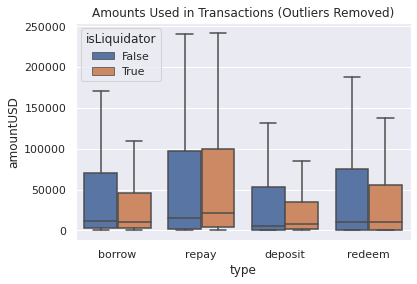

In [17]:
#create plot
sns.boxplot(data=transactions[~transactions['type'].isin(['liquidation','swap'])],x='type',y='amountUSD',hue='isLiquidator',
            showfliers=False)
plt.title('Amounts Used in Transactions (Outliers Removed)')
plt.show()

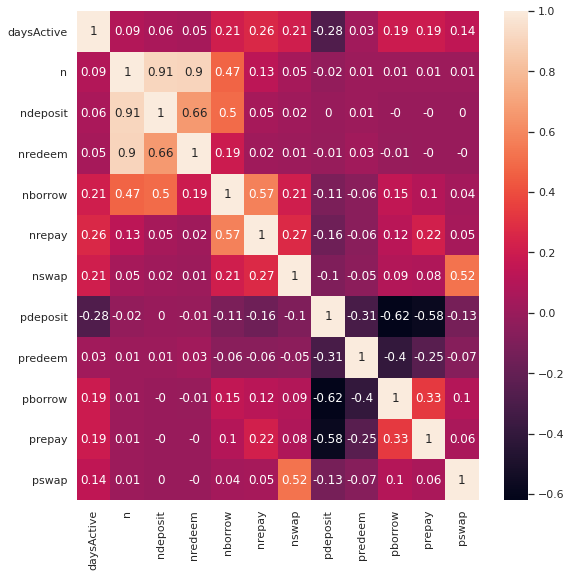

In [18]:
#get transactions for liquidators and non liquidators
tl = transactions_liquidators[~(transactions_liquidators['type']=='liquidation')]
tn = transactions_nonliquidators

#group by user, and calculate timeactive, and number of transactions
tl_counts = tl.groupby('user')['user'].count()
tl_times = (tl.groupby('user')['timestamp'].max()-tl.groupby('user')['timestamp'].min())/(3600*24)
tl_types= tl.groupby(['user','type']).size().unstack(fill_value=0)

tn_counts = tn.groupby('user')['user'].count()
tn_times = (tn.groupby('user')['timestamp'].max()-tn.groupby('user')['timestamp'].min())/(3600*24)
tn_types= tn.groupby(['user','type']).size().unstack(fill_value=0)

#create dataframe from values
df_tl = pd.DataFrame(tl_counts)
df_tl['daysActive']=tl_times
df_tl['isLiquidator']='True'
df_tl = df_tl.merge(tl_types,left_index=True,right_index=True)

df_tn = pd.DataFrame(tn_counts)
df_tn['daysActive']=tn_times
df_tn['isLiquidator']='False'
df_tn = df_tn.merge(tn_types,left_index=True,right_index=True)

#rename columns
df_tl.rename(columns={'user':'n','borrow':'nborrow','deposit':'ndeposit','redeem':'nredeem','repay':'nrepay','swap':'nswap'},inplace=True)
df_tn.rename(columns={'user':'n','borrow':'nborrow','deposit':'ndeposit','redeem':'nredeem','repay':'nrepay','swap':'nswap'},inplace=True)

#get proportions for transaction types
for t in ['borrow','deposit','redeem','repay','swap']:
    df_tl['p'+t]=df_tl['n'+t]/df_tl['n']
    df_tn['p'+t]=df_tn['n'+t]/df_tn['n']

#create dataframe for liquidator transactions and nonliquidator transactions
df_t = df_tl.append(df_tn)

#reorder columns
df_t = df_t[['isLiquidator','daysActive','n','ndeposit','nredeem','nborrow','nrepay','nswap','pdeposit','predeem','pborrow','prepay','pswap']]

#create heatmap of feature correlations
plt.figure(figsize=(9,9))
sns.heatmap(df_t.corr().round(2),annot=True)
plt.show()

In [19]:
df_tl[['nborrow','nrepay','ndeposit','nredeem','nswap']].describe()

,nborrow,nrepay,ndeposit,nredeem,nswap
count,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000
mean,14.382249,7.196167,9.959657,4.077660,0.376198
std,36.853860,30.057586,26.138909,13.701187,1.433588
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000
50%,5.000000,2.000000,3.000000,1.000000,0.000000
75%,13.000000,5.000000,9.000000,3.000000,0.000000
max,773.000000,997.000000,445.000000,267.000000,25.000000
